In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 2s (59.9 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-

In [2]:
#@title Load Package

import gc
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model

seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Load custom functions

import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/ADL/project')

from config import RAW_DATA_DIR, PROCESSED_DATA_DIR, POS_DATA_DIR, NEG_DATA_DIR, MODEL_DIR, RES_DIR
from processing import read_full_image
from create_model import create_one_zoom_model
from plot_heatmap import label_prediction, label_heatmap_onezoom

train_file = ["101", "094", "110", "016", "078", "031", "064"]
test_file = ["091", "075", "094", "084"]

In [4]:
#@title Build Model

model = create_one_zoom_model()

model.compile(loss=losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

87910968/87910968 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                              

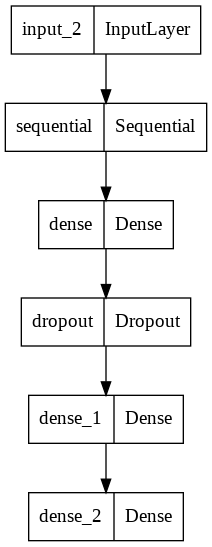

In [ ]:
base_model_structure = os.path.join(MODEL_DIR, 'model_onezoom.png')
plot_model(model, to_file=base_model_structure)

In [ ]:
#@title Training

sampling_times = 10
nsamples = 200
level = 5
factor = 2 ** level
val_split = 0.3

train_loss_lst = []
train_accuracy_lst = []
val_loss_lst = []
val_accuracy_lst = []


for s_i in range(sampling_times):

  for slide_num in train_file:
    print("\nStart Processing for", slide_num)
    
    slide_image = read_full_image(slide_num, level=level, ifmask=False)
    mask_image = read_full_image(slide_num, level=level, ifmask=True)

    # Generate samples and train model
    neg_i = 0

    print("Sampling", s_i)
    start_ind = s_i * nsamples
    end_ind = (s_i+1) * nsamples

    # positive samples
    print("Generating positive samples......")
    pos_file = os.path.join(POS_DATA_DIR, f"{slide_num}_567_{s_i}.npy")

    if not os.path.exists(pos_file):
      print(f"{pos_file} not exists!!!")
    else:
      print("------Load samples-------")
      pos_pitch_lst = np.load(pos_file)[0]

    train_dataset = tf.data.Dataset.from_tensor_slices(
        (pos_pitch_lst[int(val_split*nsamples) :], 
          np.array([1.0] * nsamples)[int(val_split*nsamples) :])
        )
    val_dataset = tf.data.Dataset.from_tensor_slices(
        (pos_pitch_lst[: int(val_split*nsamples)], 
          np.array([1.0] * nsamples)[: int(val_split*nsamples)])
        )

    del pos_pitch_lst
    gc.collect()
    

    # negative samples
    print("Generating negative samples......")
    neg_file = os.path.join(NEG_DATA_DIR, f"{slide_num}_567_{s_i}.npy")

    if not os.path.exists(neg_file):
      print(f"{pos_file} not exists!!!")
    else:
      print("------Load samples-------")
      neg_pitch_lst = np.load(neg_file)[0]

    train_dataset = train_dataset.concatenate(
        tf.data.Dataset.from_tensor_slices(
            (neg_pitch_lst[int(val_split*nsamples) :], 
              np.array([0.0] * nsamples)[int(val_split*nsamples) :])
          )
        )
    
    val_dataset = val_dataset.concatenate(
        tf.data.Dataset.from_tensor_slices(
            (neg_pitch_lst[: int(val_split*nsamples)], 
              np.array([0.0] * nsamples)[: int(val_split*nsamples)])
          )
        )
    
    del neg_pitch_lst
    gc.collect()

    # Prepare dataset
    print("Prepare dataset......")
    BATCH_SIZE = 64
    SHUFFLE_BUFFER_SIZE = int(nsamples*2*(1-val_split))
    train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    
    BATCH_SIZE = 64
    SHUFFLE_BUFFER_SIZE = int(nsamples*2*val_split)
    val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

    print("Train model......")
    checkpoint_path = os.path.join(MODEL_DIR, "model_onezoom_5_200.ckpt")
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, save_weights_only=True, verbose=1)
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=2, callbacks=[cp_callback])

    train_loss_lst.extend(history.history["loss"])
    train_accuracy_lst.extend(history.history["binary_accuracy"])
    val_loss_lst.extend(history.history["val_loss"])
    val_accuracy_lst.extend(history.history["val_binary_accuracy"])

    res_df = pd.DataFrame({
        "train_loss_lst": train_loss_lst,
        "train_accuracy_lst": train_accuracy_lst,
        "val_loss_lst": val_loss_lst,
        "val_accuracy_lst": val_accuracy_lst
    })
    res_file = os.path.join(RES_DIR, "res_onezoom_5_200.csv")
    res_df.to_csv(res_file, index=False)




Start Processing for 101
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101.tif with width: 4352, height: 2240
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101_mask.tif with width: 4352, height: 2240
Sampling 0
Generating positive samples......
------Load samples-------
Generating negative samples......
------Load samples-------
Prepare dataset......
Train model......
Epoch 1/2
5/5 [==============================] - ETA: 0s - loss: 0.4388 - binary_accuracy: 0.8214
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/ADL/project/model/model_onezoom_5_200.ckpt
5/5 [==============================] - 22s 2s/step - loss: 0.4388 - binary_accuracy: 0.8214 - val_loss: 0.1203 - val_binary_accuracy: 0.9750
Epoch 2/2
5/5 [==============================] - ETA: 0s - loss: 0.1227 - binary_accuracy: 0.9643
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/ADL/project/model/model_onezoom_5_20

In [ ]:
fig = px.line(
    res_df, 
    x=range(len(res_df)), 
    y=["train_loss_lst", "val_loss_lst"], 
    markers=True)
fig.show()

In [ ]:
fig = px.line(
    res_df, 
    x=range(len(res_df)), 
    y=["train_accuracy_lst", "val_accuracy_lst"], 
    markers=True)
fig.show()

In [ ]:
#@title Load Model

checkpoint_path = os.path.join(MODEL_DIR, "model_onezoom_5_200.ckpt")
# Loads the weights
model.load_weights(checkpoint_path)


Label heatmap for 091
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091.tif with width: 1920, height: 1680
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091_mask.tif with width: 1920, height: 1680
The shape of predict_mask (1680, 1920)
The number of tumor of predict_mask 0.0
1.0 [[0.00250946]]
1.0 [[0.00315353]]
1.0 [[0.01023109]]
1.0 [[0.00510604]]
1.0 [[0.01416478]]
1.0 [[0.00219326]]
1.0 [[0.00384173]]
1.0 [[0.00461305]]
1.0 [[0.00762667]]
1.0 [[0.00251017]]
1.0 [[0.00248999]]
1.0 [[0.00168997]]
1.0 [[0.00221407]]
1.0 [[0.0039468]]
1.0 [[0.00315348]]
1.0 [[0.00711701]]
1.0 [[0.01225048]]
1.0 [[0.00642236]]
1.0 [[0.00353652]]
1.0 [[0.00275869]]
1.0 [[0.00476134]]
1.0 [[0.005474]]
1.0 [[0.00221438]]
1.0 [[0.00100141]]
1.0 [[0.00193069]]
1.0 [[0.00170447]]
1.0 [[0.00152764]]
1.0 [[0.00086344]]
1.0 [[0.00694406]]
1.0 [[0.00814708]]
1.0 [[0.0101888]]
1.0 [[0.01655648]]
1.0 [[0.01371891]]
1.0 [[0.00426718

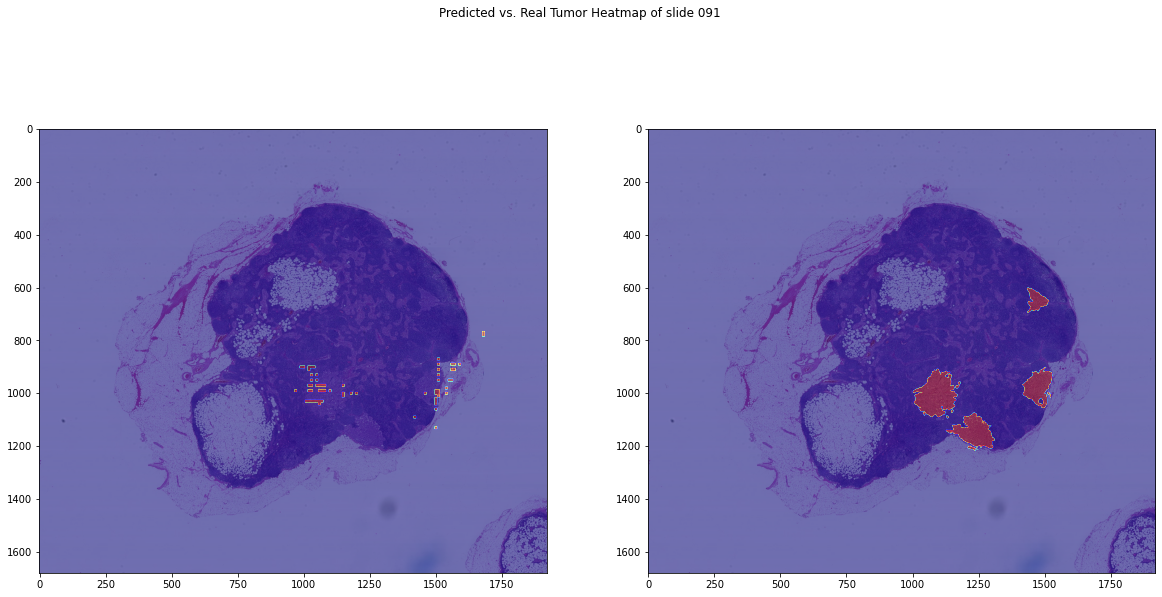


Label heatmap for 075
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075.tif with width: 2816, height: 2464
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075_mask.tif with width: 2816, height: 2464
The shape of predict_mask (2464, 2816)
The number of tumor of predict_mask 0.0
1.0 [[0.00066262]]
1.0 [[0.00099305]]
1.0 [[0.00097026]]
1.0 [[0.00140723]]
1.0 [[0.00086886]]
1.0 [[0.00098514]]
1.0 [[0.0020724]]
1.0 [[0.00147111]]
1.0 [[0.00115371]]
1.0 [[0.00151763]]
1.0 [[0.00093165]]
1.0 [[0.00183284]]
1.0 [[0.003304]]
1.0 [[0.00123078]]
1.0 [[0.00048985]]
1.0 [[0.00070309]]
1.0 [[0.00107253]]
1.0 [[0.00127122]]
1.0 [[0.0014085]]
1.0 [[0.00305106]]
1.0 [[0.00136834]]
1.0 [[0.00197069]]
1.0 [[0.00117364]]
1.0 [[0.00433482]]
1.0 [[0.00298252]]
1.0 [[0.00491579]]
1.0 [[0.00139715]]
1.0 [[0.0034346]]
1.0 [[0.00328606]]
1.0 [[0.00415358]]
1.0 [[0.00203521]]
1.0 [[0.00371359]]
1.0 [[0.00168806]]
1.0 [[0.00131043]

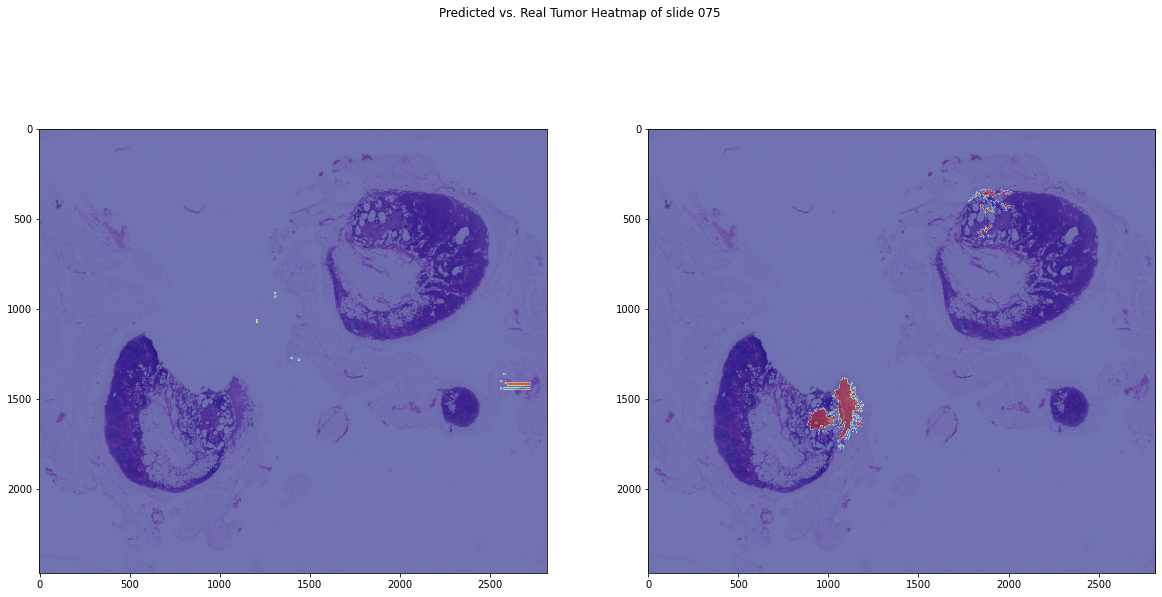


Label heatmap for 094
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094.tif with width: 3712, height: 3136
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094_mask.tif with width: 3712, height: 3136
The shape of predict_mask (3136, 3712)
The number of tumor of predict_mask 0.0
1.0 [[0.05262453]]
1.0 [[0.06921892]]
1.0 [[0.02951822]]
1.0 [[0.03606605]]
1.0 [[0.07563715]]
1.0 [[0.0307991]]
1.0 [[0.04443542]]
1.0 [[0.17932262]]
1.0 [[0.03897198]]
1.0 [[0.04086625]]
1.0 [[0.10657126]]
1.0 [[0.04242541]]
1.0 [[0.3010113]]
1.0 [[0.12402567]]
1.0 [[0.32191393]]
1.0 [[0.03850577]]
1.0 [[0.05505195]]
1.0 [[0.0234187]]
1.0 [[0.00925349]]
1.0 [[0.00795462]]
1.0 [[0.02658406]]
1.0 [[0.02883238]]
1.0 [[0.01591903]]
1.0 [[0.06219333]]
1.0 [[0.01799192]]
1.0 [[0.1310629]]
1.0 [[0.35522583]]
1.0 [[0.09346297]]
1.0 [[0.18159427]]
1.0 [[0.17292689]]
1.0 [[0.21731658]]
1.0 [[0.7420692]]
1.0 [[0.07462624]]
1.0 [[0.16727228]

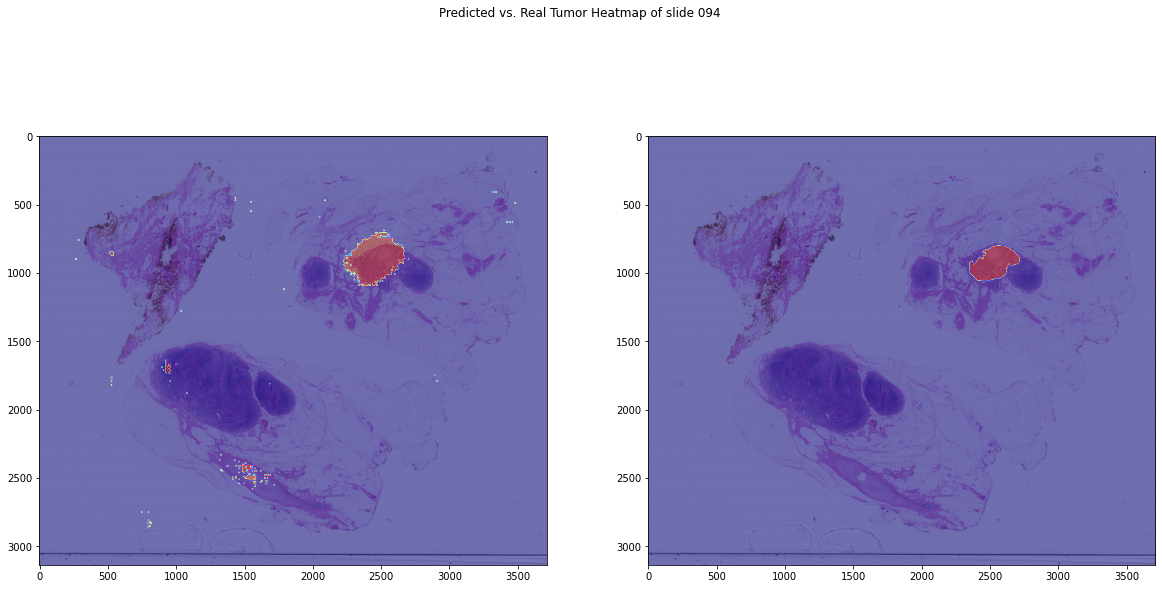


Label heatmap for 084
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084.tif with width: 2048, height: 2688
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084_mask.tif with width: 2048, height: 2688
The shape of predict_mask (2688, 2048)
The number of tumor of predict_mask 0.0
1.0 [[0.08731354]]
1.0 [[0.02658228]]
1.0 [[0.0247562]]
1.0 [[0.01583079]]
1.0 [[0.02693006]]
1.0 [[0.03365568]]
1.0 [[0.01319605]]
1.0 [[0.00663821]]
1.0 [[0.00580628]]
1.0 [[0.00115316]]
1.0 [[0.00166262]]
1.0 [[0.00321125]]
1.0 [[0.00271723]]
1.0 [[0.0015255]]
1.0 [[0.00308697]]
1.0 [[0.00203061]]
1.0 [[0.00133006]]
1.0 [[0.00221085]]
1.0 [[0.00094512]]
1.0 [[0.0010679]]
1.0 [[0.01787778]]
1.0 [[0.1883733]]
1.0 [[0.0166202]]
1.0 [[0.01685426]]
1.0 [[0.00699939]]
1.0 [[0.01288982]]
1.0 [[0.00707449]]
1.0 [[0.00524785]]
1.0 [[0.00377486]]
1.0 [[0.00605536]]
1.0 [[0.00108438]]
1.0 [[0.00377634]]
1.0 [[0.00584865]]
1.0 [[0.00350089]

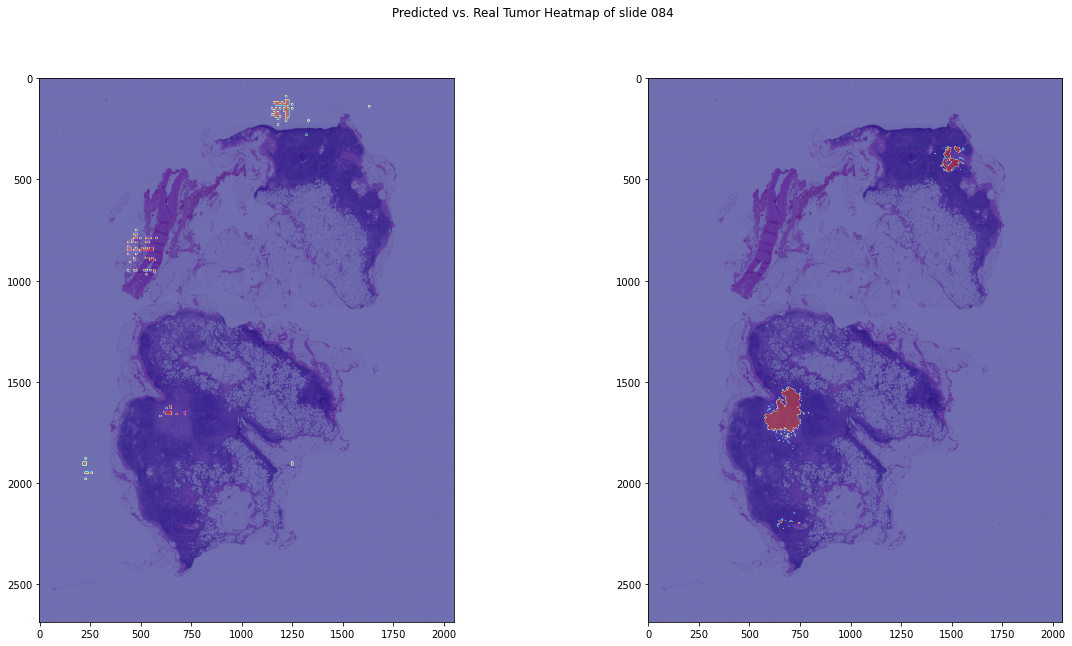

In [ ]:
#@title Generate heatmap

for slide_num in test_file:
  print("\nLabel heatmap for", slide_num)
  
  level = 5
  slide_image = read_full_image(slide_num, level=level, ifmask=False)
  mask_image = read_full_image(slide_num, level=level, ifmask=True)

  predict_mask = np.zeros(mask_image.shape, dtype=float)
  print("The shape of predict_mask", predict_mask.shape)
  print("The number of tumor of predict_mask", predict_mask.sum())

  predict_mask = label_heatmap_onezoom(
      slide_image, mask_image, predict_mask, level=5,
      threshold=0.5, step=10, patch_len=299, 
      show_res=True, verbose=0)
  print("The number of tumor of predict_mask after labeling", predict_mask.sum())
  
  f, axarr = plt.subplots(1,2) 
  f.set_figheight(10)
  f.set_figwidth(20)
  f.suptitle(f'Predicted vs. Real Tumor Heatmap of slide {slide_num}')
  axarr[0].imshow(slide_image)
  axarr[0].imshow(predict_mask, cmap='jet', alpha=0.5)
  axarr[1].imshow(slide_image)
  axarr[1].imshow(mask_image, cmap='jet', alpha=0.5)
  plt.show()